
# Studying real social network

Social network platforms like Facebook are becoming major sources of information channels. On these new media platforms, everyone acts as both information generator and consumer. In a sense, the spreading of information, or opinions, shares some resemblance with disease spreading. Instead of the disease infecting one person to the next, information is spread from one person to the next. 


**SIR model in information spreading**

As previous, SIR model is utilised here, to analyse the spread of information. In the context of Facebook (FB), a particular message that originates from a single or a group of FB accounts.  So the traditional SIR model (in disease spreading) can be mapped onto information spreading, as follows:

**S**usceptible - a person has not read or shared the particular FB update/message/news.

**I**nfected - the person has shared it and the FB update/message remains visible to its FB friends.

**R**emoved - the person has  deleted the FB update/message. So none of its FB friends can share the message.

## Problem statement

The maximization of viral (information) spreading through selecting the best set of seed nodes is being explored here. This means finding the best seed nodes to infect/start messaging in the initialisation round, such that the information can reach the widest population (with fixed $\beta$ and $\alpha$ values)? $\beta$ is the probability that a person would spread the FB message/information to each of its 'susceptible' connections. $\alpha$ is the probability that the FB message is no longer visible.

Real social networks are complicated, with more intricate local and global structures like assortativity, clustering and communities; They are also much larger with up to billions of nodes for Facebook and Twitter. Here, the New Orleans Facebook network is used to study the information spreading over real social networks. **The aim is try to find the 10 (most influential) nodes that maximizes the final percentage of infected nodes.**

*import libraries*

In [35]:
import networkx as nx 
import numpy as np 

%matplotlib inline 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches 
from __future__ import unicode_literals 
import random 
from tqdm import tqdm 
import sys 
import operator 
from enum import * # used for the states S,I,R

In [2]:
class State(Enum): # define the three states of the nodes.
    Succeptible = 0
    Infected = 1
    Removed = 2

In [3]:
def reset(G):
    """ Initialise/reset all the nodes in the network, before experiment"""
    nx.set_node_attributes(G, State.Succeptible,'state')
        

In [4]:
def initialise_infection_random(G, num_to_infect):
    """Set random selection of nodes to be infected"""
    nodes_to_infect = random.sample(G.nodes(), num_to_infect)
    for n in nodes_to_infect:
        G.nodes[n]['state'] = State.Infected
    return nodes_to_infect

def execute_one_step(G, model):
    """execute the infection model"""
    for n in G:
        model(n, G)

def get_infection_stats(G):
    """Creates lists of nodes in the graph G that are susceptible, infected and removed"""
    infected = []
    succeptible = []
    removed = []
    for n in G:
        if G.nodes[n]['state'] == State.Infected:
            infected.append(n)
        elif G.nodes[n]['state'] == State.Succeptible:
            succeptible.append(n)
        else:
            removed.append(n)
    return succeptible, infected, removed

def print_infection_stats(G):
    """Prints the number of susceptible, infected and removed nodes in graph G."""
    s,i,r = get_infection_stats(G)
    print("Susceptible: %d Infected: %d Removed %d"% (len(s),len(i),len(r)))

def transmission_model_factory(beta=0.03, alpha=0.05):
    """beta: specifies the rate of infection (movement from S to I)
    alpha: specifies the rate of removal (movement from I to R)"""
    def m(n, G):
        if G.nodes[n]['state'] == State.Infected:
            # infect susceptible neighbours with probability pInfect
            for k in G.neighbors(n):
                if G.nodes[k]['state'] == State.Succeptible:
                    if random.random() <= beta:
                        G.nodes[k]['state'] = State.Infected
            if random.random() <= alpha:
                G.nodes[n]['state'] = State.Removed                
    return m

In [5]:
def run_spread_simulation(G, model, initially_infected, run_visualise=False):
    """Runs a single simulation of infection on the graph G, using the specified model"""
    #initially_infected = initialise_infection_degree(G, initial_infection_count)

    s_results = []
    i_results = []
    r_results = []

    dt = 0
    s,i,r = get_infection_stats(G)
    
    pos = nx.spring_layout(G, k=.75)
    
    while len(i) > 0:
        execute_one_step(G, model)
        dt += 1
        s,i,r = get_infection_stats(G)
        s_results.append(len(s))
        i_results.append(len(i))
        r_results.append(len(r))
        sys.stderr.write('\rInfected: %d time step: %d' % (len(i), dt))
        sys.stderr.flush()
        if run_visualise:
            draw_network_to_file(G,pos,dt,initially_infected)
    return s_results, i_results, r_results, dt, initially_infected

def plot_infection(S,I,R,G):
    """Creates a plot of the S,I,R output of a spread simulation"""
    peak_incidence = max(I)
    peak_time = I.index(max(I))
    total_infected = S[0]-S[-1]

    fig_size= [18,13]
    plt.rcParams.update({'font.size': 14, "figure.figsize": fig_size})
    xvalues = range(len(S))
    plt.plot(xvalues, S, color='g', linestyle='-', label="S")
    plt.plot(xvalues, I, color='b', linestyle='-', label="I")
    plt.plot(xvalues, R, color='r', linestyle='-', label="R")
    plt.axhline(peak_incidence, color='b', linestyle='--', label="Peak Indidence")
    plt.annotate(str(peak_incidence),xy=(1,peak_incidence+10), color='b')
    plt.axvline(peak_time, color='b', linestyle=':', label="Peak Time")
    plt.annotate(str(peak_time),xy=(peak_time+1,8), color='b')
    plt.axhline(total_infected, color='r', linestyle='--', label="Total Infected")
    plt.annotate(str(total_infected),xy=(1,total_infected+10), color='r')
    plt.legend()
    plt.xlabel('time step')
    plt.ylabel('Count')
    plt.title('SIR for network size ' + str(G.order()))
    plt.show()
    
def draw_network_to_file(G,pos,t, initially_infected):
    # create the layout
    states = []
    for n in G.nodes():
        if n in initially_infected:
            states.append(3)
        else:
            states.append(G.nodes[n]['state']) 
    from matplotlib import colors
    cmap = colors.ListedColormap(['green', 'blue','red', 'yellow'])
    bounds=[0,1,2,3]

    # draw all the nodes and the edges 
    nx.draw_networkx_nodes(G,pos,cmap=cmap,alpha=0.5,node_size=170, node_color=states)
    nx.draw_networkx_edges(G,pos,alpha=0.075)
    plt.savefig("images/g"+str(t)+".png")
    plt.clf()
    
def plotDistribution(_influences):
    plt.hist(_influences,range=[0,1],bins=30)
    plt.title("Realisations")
    plt.xlabel("Number of infected nodes / Total number of nodes")
    plt.ylabel("Frequency")
    plt.show()

## Setting up experiment
Parameters specified:

1. Size of network $N$
2. Facebook network $FB$
3. The transmission model $m$ that specifies how a node infects others
4. The number of initial seed nodes $ini$ to spread the information (initial infected nodes)



The Facebook Network Data of New Orleans used in the 2009 research article 'On the Evolution of User Interaction in Facebook' by Bimal Viswanath and Alan Mislove and Meeyoung Cha and Krishna P. Gummadi, published in Proceedings of the 2nd ACM SIGCOMM Workshop on Social Networks (http://socialnetworks.mpi-sws.org/data-wosn2009.html).

In [34]:
#import facebook network data
fh=open("facebook-links.txt","rb")
FB=nx.read_edgelist(fh,nodetype=int,data = False)

#check the total size of the network
N = FB.order()
L = FB.size()
print('The Facebook network contains ', N , ' nodes, and ', L, ' edges.')

The Facebook network contains  63731  nodes, and  817090  edges.


In [32]:
# initial seed nodes
ini = 10 
sampleSize = 5 

$\beta$ is the probability that a person would spread the FB message/information to each of its 'susceptible' connections. $\alpha$ is the probability that the FB message is no longer visible.

In [36]:
m = transmission_model_factory(beta=0.08, alpha=0.5) 

**Running Monte Carlo simulations picking random seeds during initialisation**

Infected: 0 time step: 22734

The expected influence of the seed nodes is 0.642246316549246


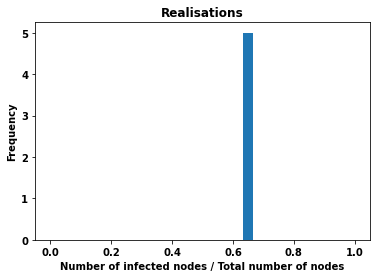

In [33]:
# run Monte Carlo simulations
Influences = []  
for i in range(sampleSize):
    reset(FB) 
    initially_infected = initialise_infection_random(FB, ini)
    S, I, R, endtime, ii = run_spread_simulation(FB, m, initially_infected)
    Influences.append(float(R[-1])/len(FB))
print('The expected influence of the seed nodes is', np.average(Influences))
plotDistribution(Influences)